In [1]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64
import os
from openai import OpenAI 

from IPython.display import Image, display, Audio, Markdown


In [2]:
MODEL="gpt-4o"
# MODEL="gpt-4-turbo"
openai_api_key = "sk-proj-vq7xTCAdU9d2V0HKp55jT3BlbkFJBTOBsGNVO9ykIuxH5ZrJ"
client = OpenAI(api_key=openai_api_key)

In [1164]:
# VIDEO_PATH = "observation_test.mp4"
# VIDEO_PATH = "blue_bowl_place.mp4"
VIDEO_PATH = "test2.mp4"
# VIDEO_PATH = "pi_test_2_short.mp4"
# VIDEO_PATH = "pi_test_2nd_half.mp4"
# VIDEO_PATH = "chopstick_video.mp4"


In [1165]:
DIFFERENCE_IN_IMAGES_SYSTEM_PROMPT="""

You will be presented with images of a specific environment featuring a table with various objects and a robot arm performing tasks. The environment includes the following components:

**Environment and Components:**
- **Objects:**
  - Black Chopstick
  - Aluminum Container
  - Plastic Bowl
  - Metal Spoon
  - Cardboard Food Container
  - Glass Bowl
- **Destinations:**
  - Transparent Plastic Box (located on the black table)
  - Blue Bin (located next to the black table)
- **Robot Mechanism:**
  - Robot Arm equipped with a Gripper

**Task:**
Your task is to identify and list any changes in the video, specifically focusing on the objects.
"""
DIFFERENCE_IN_IMAGES_QUESTION="""
What has changed in the two images? Focus on the objects.

**Instructions:**
- Examine the images to determine which objects have moved or changed in any way.
- Return your answer as a JSON object listing only the objects that have moved or changed.

**Format:**
Return your answer as a JSON object, listing only the objects that have moved or changed.

**Example:**
{
  "moved_objects": [
    "Black Chopstick",
    "Plastic Bowl"
  ]
}

Only mention objects where you are 100% sure they have moved significantly. This means there must be a notable move in position between at least 2 images. Eg if the image is no longer in its starting position it has moved. 
Ignore the robot arm, focus only on the objects. Err on the side of caution when not sure. 
Think step by step.

"""

SYSTEM_PROMPT="""
**Comprehensive Video Task Analysis Framework**

**Environment and Components:**
- **Objects:**
  - Black Chopstick
  - Aluminum Takeout Container
  - Plastic Bowl
  - Orange Plate
  - Metal Spoon
  - Cardboard Food Container
  - Glass Bowl
- **Destinations:**
  - Transparent Plastic Box (on top of the black table)
  - Blue Trash Bin (next to the black table)
- **Robot Mechanism:**
  - Robot Arm equipped with a Gripper

**Task Definitions:**
- **Pick up OBJECT**: Recognized as complete when the robot's gripper has securely grasped the object, and it is fully suspended in the air with no contact with any surfaces.
- **Put OBJECT into DESTINATION**: Confirmed as complete when the object is inside the destination, and the gripper has retracted, fully releasing the object.

**Object Destination Rules:**
- Only the Aluminum Container and Cardboard Food Container go into the blue bin.
- The rest of the objects go into the clear plastic box on the table.
"""

QUESTION = """
**Objective:**
Determine and report the tasks successfully completed by a robot in a video sequence involving the manipulation of various objects.

**Summary Criteria:**
- Identify and list tasks that have been conclusively completed. The object must be visibly manipulated by the robot’s gripper, and tasks must include a clear transition from an initial to a final position.
- Ensure each reported task matches the visual evidence available in the video.
- Think carefully what the destination is, and follow the object destination rules above.

**High-Level Summary Instructions:**
Provide a summary of each task type (Pick up and Put) that has been completed throughout the video. Specify the object involved and its final destination if applicable. Use the following example to guide your report:

**Example Summary Report:**
{
  "tasks": [
    {
      "task": "Pick up Plastic Bowl",
      "details": "Plastic bowl clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.",
      "image_range": "2-6"
    },
    {
      "task": "Put Plastic Bowl into Clear Plastic Box",
      "details": "After picking up, the plastic bowl is observed being placed into the plastic box. The task is confirmed complete as the robot's gripper retracts and the plastic bowl is no longer in contact with the gripper.",
      "image_range": "7-9"
    }
  ]
}

**Instructions for Use:**
Use this format to create a coherent report on the tasks observed in the video. Be specific about each task and ensure that the completion status is backed by clear visual evidence from the video. Do not make up any tasks that are not shown in the images of the video. It is important to remember the task definitions and what classifies as complete. Full compliance with the completion conditions is required to confirm each task.
List the tasks in chronological order.
"""


1116
30.0
skipping 30 frames
Extracted 10 frames


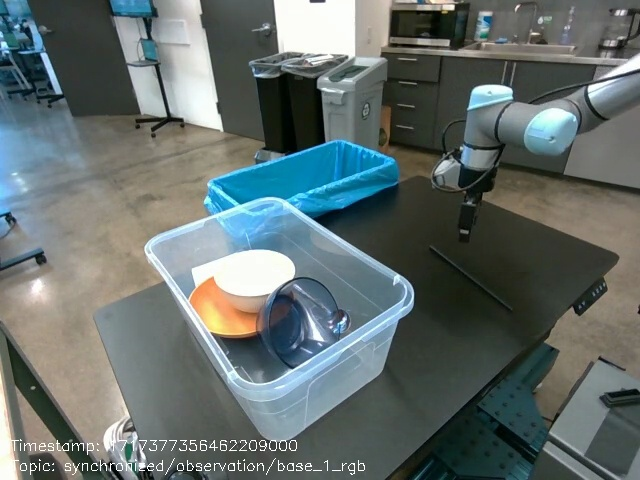

In [48]:
def process_video(video_path, seconds_per_frame=0.5):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(total_frames)
    fps = video.get(cv2.CAP_PROP_FPS)
    print(fps)
    frames_to_skip = int(fps * seconds_per_frame)
    print(f"skipping {frames_to_skip} frames")
    curr_frame=600

    # Loop through the video and extract frames at specified sampling rate
    # while curr_frame < total_frames - 1:
    while curr_frame < 900:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    print(f"Extracted {len(base64Frames)} frames")

    return base64Frames

base64Frames = process_video(VIDEO_PATH, seconds_per_frame=1)


## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.5)

In [60]:
qa_visual_response = client.chat.completions.create(
    model=MODEL,
    
    messages=[
    # {"role": "system", "content": "Do you see a chopstick in the video?"},
    {"role": "system", "content": DIFFERENCE_IN_IMAGES_SYSTEM_PROMPT},
    {"role": "user", "content": [
        "These are the 10 images from the video.",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}}, base64Frames),
        DIFFERENCE_IN_IMAGES_QUESTION
        ],
    }
    ],
    temperature=0,
)
print(qa_visual_response.choices[0].message.content)

AttributeError: 'coroutine' object has no attribute 'choices'

In [11]:
import json
import re

def extract_json_from_response(response):
    """
    Extracts and parses a JSON object from a given response string.
    """
    try:
        match = re.search(r"\{.*\}", response, re.DOTALL)
        if match:
            json_string = match.group(0)  # Extract the matched JSON string including braces
            json_response = json.loads(json_string)
            return json_response
        else:
            print("No JSON object found in the response")
            return None
    except (IndexError, KeyError) as e:
        print(f"Error accessing LLM response: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None



In [12]:
response = qa_visual_response.choices[0].message.content
json_data = extract_json_from_response(response)
if json_data:
    print(json_data)

{'moved_objects': ['Metal Spoon', 'Aluminum Container']}


In [14]:
moved_objects = json_data["moved_objects"]
moved_objects_str = ", ".join(moved_objects)

# Append the information to the prompt
additional_info = f"""
**Object Detection Model Help**
The object detection model said the object(s) that have moved significantly are:
- {moved_objects_str}

Use the information above to inform your answer if you need.
"""

# Combine the original prompt with the additional information
final_prompt = QUESTION + additional_info

In [16]:
qa_visual_response = client.chat.completions.create(
    model=MODEL,
    
    messages=[
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": [
        "These are the images from the video.",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}}, base64Frames),
        final_prompt
        ],
    }
    ],
    temperature=0,
)
print(qa_visual_response.choices[0].message.content)

**Summary Report:**
{
  "tasks": [
    {
      "task": "Pick up Metal Spoon",
      "details": "The metal spoon is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air."
    },
    {
      "task": "Put Metal Spoon into Clear Plastic Box",
      "details": "After picking up, the metal spoon is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the metal spoon is no longer in contact with the gripper."
    },
    {
      "task": "Pick up Aluminum Container",
      "details": "The aluminum container is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air."
    },
    {
      "task": "Put Aluminum Container into Blue Trash Bin",
      "details": "After picking up, the aluminum container is observed being placed into the blue trash bin. The task is confirmed complete as the robot's gripper retracts and the aluminum container is no long

In [17]:
response = qa_visual_response.choices[0].message.content
json_data = extract_json_from_response(response)
if json_data:
    print(json_data)

{'tasks': [{'task': 'Pick up Metal Spoon', 'details': 'The metal spoon is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.'}, {'task': 'Put Metal Spoon into Clear Plastic Box', 'details': "After picking up, the metal spoon is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the metal spoon is no longer in contact with the gripper."}, {'task': 'Pick up Aluminum Container', 'details': 'The aluminum container is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.'}, {'task': 'Put Aluminum Container into Blue Trash Bin', 'details': "After picking up, the aluminum container is observed being placed into the blue trash bin. The task is confirmed complete as the robot's gripper retracts and the aluminum container is no longer in contact with the gripper."}]}


In [21]:
import asyncio
from openai import AsyncOpenAI
client = AsyncOpenAI(api_key=openai_api_key)


In [121]:
def process_video(video_path, start_frame, end_frame, seconds_per_frame=0.5):
    base64Frames = []
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame = start_frame
    print(start_frame)
    print(end_frame)

    while curr_frame < end_frame:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()
    return base64Frames

def extract_json_from_response(response):
    try:
        match = re.search(r"\{.*\}", response, re.DOTALL)
        if match:
            return json.loads(match.group(0))
        else:
            print("No JSON object found in the response")
            return None
    except Exception as e:
        print(f"Error decoding JSON or accessing response: {e}")
        return None

async def process_frame_segment(start_frame, end_frame, system_prompt, user_prompt, include_images=True):
    frames = process_video(VIDEO_PATH, start_frame, end_frame, seconds_per_frame=1)
    image_content = [{"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}} for x in frames] if include_images else []
    response = await client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": [
                "These are the 10 images from the video." if include_images else "Reviewing the following changes:",
                *image_content,
                user_prompt
            ]}
        ],
        temperature=0,
    )
    return response, frames  # Return frames if needed for further processing

async def annotate_video(video_path):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.release()

    segment_size = 300
    frame_ranges = [(max(0, i - segment_size), min(total_frames, i)) for i in range(segment_size, total_frames + segment_size, segment_size)]
    first_round_tasks = [process_frame_segment(start, end, DIFFERENCE_IN_IMAGES_SYSTEM_PROMPT, DIFFERENCE_IN_IMAGES_QUESTION) for start, end in frame_ranges]
    
    first_round_responses, first_round_frames = zip(*await asyncio.gather(*first_round_tasks))
    print("done first round")
    changes = [extract_json_from_response(response.choices[0].message.content) for response in first_round_responses]

    # Prepare the second round of requests based on detected changes
    second_round_tasks = []
    for (start_frame, end_frame), change, frames in zip(frame_ranges, changes, first_round_frames):
        if change:
            message_content = json.dumps(change)  # Converting change to JSON string directly
            second_round_tasks.append(
                process_frame_segment(
                    start_frame,
                    end_frame,
                    SYSTEM_PROMPT,
                    QUESTION + message_content,
                    include_images=True  # Optional, set to False if no images are needed
                )
            )

    if second_round_tasks:
        second_round_responses = await asyncio.gather(*second_round_tasks)
        print("done second round")
        actions = [extract_json_from_response(resp.choices[0].message.content) for resp, _ in second_round_responses]
        # Combine actions with frame ranges
        combined_results = [{"frame_range": f"{start}-{end}", "actions": action} for ((start, end), action) in zip(frame_ranges, actions)]
        return changes, combined_results
    else:
        return changes, []

# Execute the main function and capture the output
changes_detected, robot_actions = await annotate_video(VIDEO_PATH)

0
300
300
600
600
900
900
1116


CancelledError: 

In [76]:
changes_detected

[{'moved_objects': ['Glass Bowl', 'Cardboard Food Container']},
 {'moved_objects': ['Orange Plate', 'White Bowl']},
 {'moved_objects': ['Metal Spoon', 'Aluminum Container']},
 {'moved_objects': ['Black Chopstick']}]

In [81]:
robot_actions[2]

{'frame_range': '600-900',
 'actions': {'tasks': [{'task': 'Pick up Metal Spoon',
    'details': 'The metal spoon is clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.',
    'image_range': '1-4'},
   {'task': 'Put Metal Spoon into Clear Plastic Box',
    'details': "After picking up, the metal spoon is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the metal spoon is no longer in contact with the gripper.",
    'image_range': '5-6'},
   {'task': 'Pick up Aluminum Container',
    'details': 'The aluminum container is clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.',
    'image_range': '7-8'},
   {'task': 'Put Aluminum Container into Blue Trash Bin',
    'details': "After picking up, the aluminum container is observed being placed into the blue trash bin. The task is confirmed complete as the robot's gripper retracts 

In [74]:
changes_detected

[{'moved_objects': ['Glass Bowl', 'Cardboard Food Container']},
 {'moved_objects': ['Plastic Bowl', 'Orange Plate']},
 {'moved_objects': ['Metal Spoon', 'Aluminum Container']},
 {'moved_objects': ['Black Chopstick']}]

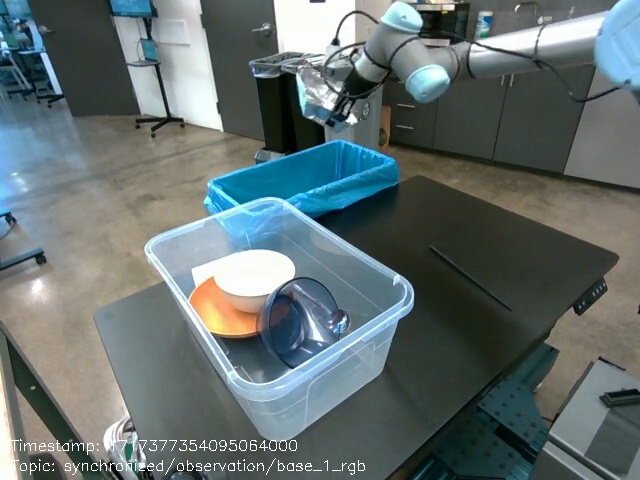

In [112]:
import cv2
from IPython.display import display, Image
import numpy as np
import base64
import io

def display_specific_frame(video_path, frame_number):
    video = cv2.VideoCapture(video_path)
    # Set the position of the video to the frame number
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = video.read()
    video.release()

    if not success:
        print("Failed to extract frame at index:", frame_number)
        return

    # Convert the frame to JPEG format
    _, buffer = cv2.imencode('.jpg', frame)
    # Encode the JPEG buffer to base64
    jpg_as_text = base64.b64encode(buffer).decode('utf-8')

    # Display the image using IPython display
    display(Image(data=base64.b64decode(jpg_as_text), width=600, format='jpg'))

# Usage: Display the 600th frame of the video
display_specific_frame(VIDEO_PATH, 825)

In [120]:
def calculate_expanded_range(start_frame, frames_to_skip, image_range, expansion_multiplier=2):
    # Extract start and end from the image range
    start_img, end_img = map(int, image_range.split('-'))
    
    # Calculate the original start and end frames
    original_start = start_frame + (start_img - 1) * frames_to_skip
    original_end = start_frame + end_img * frames_to_skip

    # Compute original window size in frames
    original_window_size = original_end - original_start
    
    # Calculate the expanded window size using the multiplier
    expanded_window_size = original_window_size * expansion_multiplier
    
    # Calculate the additional buffer needed on each side
    buffer = (expanded_window_size - original_window_size) // 2

    # Calculate the new start and end frames with additional buffer
    new_start = max(0, original_start - buffer)
    new_end = original_end + buffer

    return new_start, new_end

# Example usage
start_frame = 600
frames_to_skip = 30
image_range = "1-4"
expanded_range = calculate_expanded_range(start_frame, frames_to_skip, image_range, expansion_multiplier=2)
print(f"Expanded range for task: {expanded_range}")

Expanded range for task: (540, 780)


In [126]:
test = process_video(VIDEO_PATH, 540, 780, seconds_per_frame=0.25)

540
780


In [127]:
len(test)

35

In [131]:
robot_actions

[{'frame_range': '0-300',
  'actions': {'tasks': [{'task': 'Pick up Glass Bowl',
     'details': 'The glass bowl is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
     'image_range': '2-5'},
    {'task': 'Put Glass Bowl into Clear Plastic Box',
     'details': "After picking up, the glass bowl is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the glass bowl is no longer in contact with the gripper.",
     'image_range': '6-7'},
    {'task': 'Pick up Cardboard Food Container',
     'details': 'The cardboard food container is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
     'image_range': '8-9'},
    {'task': 'Put Cardboard Food Container into Blue Trash Bin',
     'details': "After picking up, the cardboard food container is observed being placed into the blue trash bin. The task is confirmed complete as th

In [137]:
TIMESTEP_PROMPT_TEMPLATE = "In less than 20 words,analyze the following task: {task_name}. What are the key actions and their implications?"

In [138]:
async def label_timestep_task(video_path, task, frames_to_skip, start_frame_of_segment):
    task_name = task['task']
    image_range = task['image_range']

    # Calculate expanded range
    expanded_start, expanded_end = calculate_expanded_range(start_frame_of_segment, frames_to_skip, image_range, expansion_multiplier=2)

    # Extract frames
    frames = process_video(video_path, expanded_start, expanded_end, seconds_per_frame=1)

    # Prepare prompt
    timestep_prompt = TIMESTEP_PROMPT_TEMPLATE.format(task_name=task_name)

    # Prepare API call
    response = await client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": [
                "Reviewing the task with expanded frames.",
                *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}}, frames),
                timestep_prompt
            ]}
        ],
        temperature=0,
    )
    return response

In [141]:
async def annotate_video_with_timesteps(video_path, robot_actions):
    tasks_to_process = []
    for action_data in robot_actions:
        start_frame_of_segment = int(action_data['frame_range'].split('-')[0])
        for task in action_data['actions']['tasks']:
            tasks_to_process.append(label_timestep_task(video_path, task, 30, start_frame_of_segment))  # Assuming 30 as frames_to_skip
    print(tasks_to_process)
    # Asynchronously process all tasks
    responses = await asyncio.gather(*tasks_to_process)
    return responses


# Execute the main function
final_responses = await annotate_video_with_timesteps(VIDEO_PATH, robot_actions)

[<coroutine object label_timestep_task at 0x2aff21070>, <coroutine object label_timestep_task at 0x2aff210e0>, <coroutine object label_timestep_task at 0x2aff21150>, <coroutine object label_timestep_task at 0x2aff3a3b0>, <coroutine object label_timestep_task at 0x2aff3bf40>, <coroutine object label_timestep_task at 0x2aff3b1b0>, <coroutine object label_timestep_task at 0x2aff39310>, <coroutine object label_timestep_task at 0x2aff39ee0>, <coroutine object label_timestep_task at 0x2aff3b680>, <coroutine object label_timestep_task at 0x2aff27990>, <coroutine object label_timestep_task at 0x2aff278b0>, <coroutine object label_timestep_task at 0x2aff27a70>, <coroutine object label_timestep_task at 0x2aff27b50>, <coroutine object label_timestep_task at 0x2aff27a00>]
0
210
120
240
180
300
210
330
300
420
330
450
420
540
450
570
540
780
690
810
750
870
810
930
810
1170
1020
1260


In [147]:
final_responses[3].choices[0].message.content

"To analyze the task of putting the Cardboard Food Container into the Blue Trash Bin, let's break down the key actions and their implications based on the provided frames:\n\n### Key Actions:\n\n1. **Identify the Cardboard Food Container:**\n   - The robot must recognize the Cardboard Food Container among the various objects on the table.\n   - Implication: Accurate object recognition is crucial to ensure the correct item is picked up.\n\n2. **Position the Gripper:**\n   - The robot arm must move the gripper to a position above the Cardboard Food Container.\n   - Implication: Precise positioning is necessary to avoid collisions with other objects and to ensure a secure grasp.\n\n3. **Pick up the Cardboard Food Container:**\n   - The gripper must securely grasp the Cardboard Food Container and lift it off the table.\n   - Implication: The gripper must apply the correct amount of force to avoid damaging the container while ensuring it does not slip.\n\n4. **Move to the Blue Trash Bin:**\

In [136]:
robot_actions[0]

{'frame_range': '0-300',
 'actions': {'tasks': [{'task': 'Pick up Glass Bowl',
    'details': 'The glass bowl is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
    'image_range': '2-5'},
   {'task': 'Put Glass Bowl into Clear Plastic Box',
    'details': "After picking up, the glass bowl is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the glass bowl is no longer in contact with the gripper.",
    'image_range': '6-7'},
   {'task': 'Pick up Cardboard Food Container',
    'details': 'The cardboard food container is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
    'image_range': '8-9'},
   {'task': 'Put Cardboard Food Container into Blue Trash Bin',
    'details': "After picking up, the cardboard food container is observed being placed into the blue trash bin. The task is confirmed complete as the robot's gr

### Testing the timestep labeling

In [1027]:
SYSTEM_PROMPT="""
**Comprehensive Video Task Analysis Framework**

**Environment and Components:**
- **Objects:**
  - Black Chopstick
  - Aluminum Takeout Container
  - Plastic Bowl
  - Orange Plate
  - Metal Spoon
  - Cardboard Food Container
  - Glass Bowl
- **Destinations:**
  - Transparent Plastic Box (on top of the black table)
  - Blue Trash Bin (next to the black table)
- **Robot Mechanism:**
  - Robot Arm equipped with a Gripper

**Task Definitions:**
- **Pick up OBJECT**: Recognized as complete when the robot's gripper has securely grasped the object, and it is fully suspended in the air with no contact with any surfaces.
- **Put OBJECT into DESTINATION**: Confirmed as complete when the object is inside the destination, and the gripper has retracted, fully releasing the object.

**Object Destination Rules:**
- Only the Aluminum Container and Cardboard Food Container go into the blue bin.
- The rest of the objects go into the clear plastic box on the table.
"""

QUESTION = """
You are presented with an action that is being carried out by the robot, namely: {action}. 
You are also presented with a sequence of {num_images} images in chronological order that make up the video of the robot doing the task in the environment. 

**Objective:**
Based on the action above the goal is to say the start image and the end image for accomplishing this action. 

**Criteria for task completion:**

***Pick up tasks:***
Start image: 
- The robot gripper must be empty and open
- There must be no contact between the gripper and any object
- There must be a significant space between the target object and the robot gripper
- The start image is the image BEFORE the first image that shows intent of the robot gripper going to pick up the object

End Image:  
- The robot gripper must be empty and open.  
- There must be a significant space between the target object and the robot gripper
- The end image is the image BEFORE the first image that shows intent of the robot gripper going to pick up the NEXT object


"""

TIMESTEP_PROMPT = """
You are reviewing a specific action performed by a robot: {action}.
This review includes a sequence of {num_images} images that chronologically depict the robot executing the task within its operational environment.

**Objective:**
Determine and identify the start and end images that accurately frame the completion of the specified action.

**Criteria for Task Completion:**

For tasks involving "picking up" an object, define the start and end images based on the following conditions:

***Start Image Criteria:***
- The robot's gripper should be open and empty.
- There should be no contact between the gripper and any object.
- A clear and noticeable space should exist between the target object and the robot's gripper.
- The 'start image' is identified as the last image just before the gripper begins to move towards the object, indicating the intent to pick it up.

***End Image Criteria:***
- The gripper remains open and empty after the task.
- A significant gap is maintained between the target object and the gripper post-task.


**Response Format:**
Your response should specify the frame numbers for the start and end images that encapsulate the action.

**Example Output:**
{
  "start_image": 3,
  "end_image": 12
}

Think step by step
"""

TIMESTEP_PROMPT_TEMPLATE = """
You are reviewing a specific action performed by a robot: {action}.
This review includes a sequence of {num_images} images that chronologically depict the robot executing the task within its operational environment.

**Objective:**
Determine and identify the start and end images that accurately frame the completion of the specified action.

**Criteria for Task Completion:**

### For "Pick Up" Tasks
Define the start and end images based on the following conditions:

***Start Image Criteria:***
- The robot's gripper should be open and empty.
- There should be no contact between the gripper and any object.
- A clear and noticeable space should exist between the target object and the robot's gripper.
- The 'start image' is identified as the image just before the gripper begins to move towards the object, indicating the intent to pick it up.

***End Image Criteria:***
- The gripper is closed and has the relevant object in the gripper
- The object is in the air 
- There is significant space from the starting position of the object on the table and its current position
- The 'end image' should be as soon as the robot gripper has successfully picked up the object, and there is space between the table and the object in the gripper.

### For "Put Object Into" Tasks
Define the start and end images based on the following conditions:

***Start Image Criteria:***
- The robot's gripper should be closed, holding the relevant object.
- The robot gripper has just finished picking up the object and is about to start moving it towards the destination. 
- The 'start image' should be before the gripper has started to move to the Destination
- The 'start image' should NOT be when the gripper is hovering over the bin / container

***End Image Criteria:***
- The robot's gripper should be open, and not touching any object
- There must be signficant space between the destination of the object, and the current state of the robot gripper. 
- The gripper must have JUST retreated from the destination
- The 'end image' should NOT be when the gripper is hovering over the bin / container



**Response Format:**
Your response should specify the frame numbers for the start and end images that encapsulate the action.The response should be only a JSON, and nothing else.

**Example Output:**
{{
  "start_image": 3,
  "end_image": 12
}}
"""



In [634]:
def process_video(video_path, seconds_per_frame=0.5, curr_frame=0, end_frame=300):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(total_frames)
    fps = video.get(cv2.CAP_PROP_FPS)
    print(fps)
    frames_to_skip = int(fps * seconds_per_frame)
    print(f"skipping {frames_to_skip} frames")

    # Loop through the video and extract frames at specified sampling rate
    # while curr_frame < total_frames - 1:
    while curr_frame < end_frame:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    print(f"Extracted {len(base64Frames)} frames")

    return base64Frames



In [505]:
qa_visual_response = client.chat.completions.create(
    model=MODEL,
    
    messages=[
    # {"role": "system", "content": "Do you see a chopstick in the video?"},
    # {"role": "system", "content": DIFFERENCE_IN_IMAGES_SYSTEM_PROMPT},
    {"role": "user", "content": [
        "These are the 10 images from the video.",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}}, base64Frames),
        DIFFERENCE_IN_IMAGES_QUESTION
        ],
    }
    ],
    temperature=0,
)
print(qa_visual_response.choices[0].message.content)

AttributeError: 'coroutine' object has no attribute 'choices'

In [945]:
robot_action_1 = robot_actions[2]

In [957]:
robot_actions

[{'frame_range': '0-300',
  'actions': {'tasks': [{'task': 'Pick up Glass Bowl',
     'details': 'The glass bowl is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
     'image_range': '2-5'},
    {'task': 'Put Glass Bowl into Clear Plastic Box',
     'details': "After picking up, the glass bowl is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the glass bowl is no longer in contact with the gripper.",
     'image_range': '6-7'},
    {'task': 'Pick up Cardboard Food Container',
     'details': 'The cardboard food container is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
     'image_range': '8-9'},
    {'task': 'Put Cardboard Food Container into Blue Trash Bin',
     'details': "After picking up, the cardboard food container is observed being placed into the blue trash bin. The task is confirmed complete as th

In [972]:
tasks_to_process = []
start_frame_of_segment = int(robot_action_1['frame_range'].split('-')[0])
for idx, task in enumerate(robot_action_1['actions']['tasks']):
    if idx == 1: 
        task_name = task['task']
        image_range = task['image_range']


In [973]:
start_frame_of_segment

600

In [974]:
print(task_name, image_range)

Put Metal Spoon into Clear Plastic Box 5-6


In [975]:
task_name

'Put Metal Spoon into Clear Plastic Box'

In [976]:
expanded_start, expanded_end = calculate_expanded_range(start_frame_of_segment, 30, image_range, expansion_multiplier=2)

In [977]:
expanded_start, expanded_end

(690, 810)

1116
30.0
skipping 15 frames
Extracted 8 frames


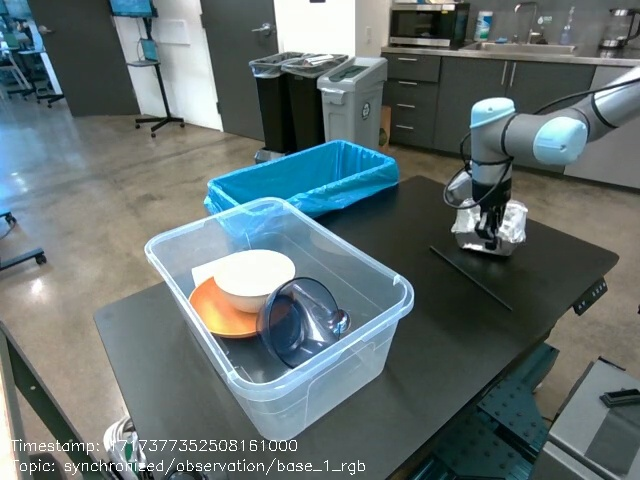

0
1
2
3
4
5
6
7


In [978]:
frames = process_video(VIDEO_PATH, seconds_per_frame=0.5, curr_frame=expanded_start, end_frame=expanded_end)

## Display the frames and audio for context
display_handle = display(None, display_id=True)
for idx, img in enumerate(frames):
    print(idx)
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.1)


In [979]:
frames = process_video(VIDEO_PATH, seconds_per_frame=0.5, curr_frame=expanded_start, end_frame=expanded_end)
display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))


1116
30.0
skipping 15 frames
Extracted 8 frames


In [980]:
num_images = len(frames)
print(f"num of images is {num_images}")

num of images is 8


In [981]:
timestep_prompt = TIMESTEP_PROMPT.format(action=task_name, num_images=num_images)

In [992]:
response = await client.chat.completions.create(
        model=MODEL,
        messages=[
            # {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": [
                "Reviewing the task with expanded frames.",
                *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}}, frames),
                timestep_prompt
            ]}
        ],
        temperature=0,
    )

In [993]:
response = response.choices[0].message.content
response

'{\n  "start_image": 1,\n  "end_image": 6\n}'

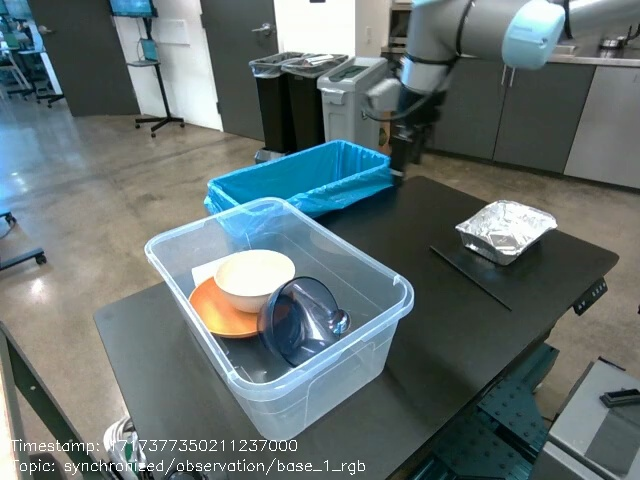

In [995]:
from IPython.display import display, Image
import base64

# Assuming 'frames' is your list of base64-encoded images
def display_specific_image(frames, image_index):
    if image_index < len(frames):
        img_data = frames[image_index]
        display(Image(data=base64.b64decode(img_data.encode("utf-8")), width=600))
    else:
        print("Image index out of range")

# Call the function with the desired image index
image_index = 4  # For the 8th image
display_specific_image(frames, image_index)

In [937]:
""" NEXT DOUBLE CLICK FOCUS SHOULD BE ON finding the fine line BETWEEN PICK UP AND PUT """

' NEXT DOUBLE CLICK FOCUS SHOULD BE ON finding the fine line BETWEEN PICK UP AND PUT '

In [938]:
def extract_json_from_response(response):
    try:
        match = re.search(r"\{.*\}", response, re.DOTALL)
        if match:
            return json.loads(match.group(0))
        else:
            print("No JSON object found in the response")
            return None
    except Exception as e:
        print(f"Error decoding JSON or accessing response: {e}")
        return None


In [939]:
ans = extract_json_from_response(response)

In [940]:
ans

{'start_image': 1, 'end_image': 1}

In [956]:
calculate_expanded_range(540, 15, '1-2', expansion_multiplier=1)

(540, 570)

In [996]:
def convert_frame_number_to_timestamp(current_frame_num, total_num_frames, fps=30):
    """
    Convert a given frame number to a timestamp.
    """
    # Calculate the total number of seconds for the current frame
    total_seconds = current_frame_num / fps

    # Calculate hours, minutes, and seconds
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = total_seconds % 60

    # Format the timestamp as HH:MM:SS
    timestamp = f"{hours:02}:{minutes:02}:{seconds:06.3f}"
    
    return timestamp

# Example usage
current_frame_num = 810
total_num_frames = 1116
timestamp = convert_frame_number_to_timestamp(current_frame_num, total_num_frames)
print(timestamp)  # Output should be 00:00:27.000

00:00:27.000


In [1000]:
def convert_frame_number_to_timestamp(current_frame_num, fps=30):
    """
    Convert a given frame number to a timestamp in MM:SS.t format, rounded to the nearest tenth of a second.
    """
    # Calculate the total number of seconds for the current frame
    total_seconds = current_frame_num / fps

    # Calculate minutes and seconds
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60

    # Round seconds to the nearest tenth
    seconds = round(seconds, 1)

    # Format the timestamp as MM:SS.t
    timestamp = f"{minutes:02}:{seconds:04.1f}"
    
    return timestamp

# Example usage
current_frame_num = 818
fps = 30
timestamp = convert_frame_number_to_timestamp(current_frame_num, fps)
print(timestamp)  # Output should be 13:30.0

00:27.3


In [1146]:
def calculate_expanded_range(
    start_frame, frames_to_skip, start_img, end_img, expansion_multiplier=2
):

    # Calculate the original start and end frames
    original_start = start_frame + (start_img - 1) * frames_to_skip
    original_end = start_frame + (end_img - 1) * frames_to_skip

    # Compute original window size in frames
    original_window_size = original_end - original_start

    # Calculate the expanded window size using the multiplier
    expanded_window_size = original_window_size * expansion_multiplier

    # Calculate the additional buffer needed on each side
    buffer = (expanded_window_size - original_window_size) // 2

    # Calculate the new start and end frames with additional buffer
    new_start = max(0, original_start - buffer)
    new_end = original_end + buffer

    return new_start, new_end
    
def extract_frames_from_video(video_path, start_frame, end_frame, seconds_per_frame=0.5):
    base64Frames = []
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    fps = video.get(cv2.CAP_PROP_FPS)
    print(total_frames)
    fps = video.get(cv2.CAP_PROP_FPS)
    print(fps)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame = start_frame

    while curr_frame < end_frame:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()
    print(f"Extracted {len(base64Frames)} frames")

    return base64Frames


In [1133]:
async def label_video_timesteps(video_path, robot_actions):
    tasks_to_process = []
    for action_data in robot_actions:
        start_frame_of_segment = int(action_data['frame_range'].split('-')[0])
        for task in action_data['actions']['tasks']:
            tasks_to_process.append(label_episode_timesteps(video_path, task, 30, start_frame_of_segment))  # Assuming 30 as frames_to_skip
    # Asynchronously process all tasks
    responses = await asyncio.gather(*tasks_to_process)
    return responses


async def label_episode_timesteps(video_path, task, frames_to_skip, start_frame_of_segment):
    """Process a single robot task by calculating the range, getting frames, and analyzing the task."""
    task_name = task['task']
    image_range = task['image_range']
    start_img, end_img = map(int, image_range.split('-'))

    # Calculate expanded frame range based on image_range
    expanded_start, expanded_end = calculate_expanded_range(start_frame_of_segment, frames_to_skip, start_img, end_img, expansion_multiplier=2)
    frames = extract_frames_from_video(video_path, seconds_per_frame=0.5, start_frame=expanded_start, end_frame=expanded_end)
    num_images = len(frames)
    timestep_prompt = TIMESTEP_PROMPT_TEMPLATE.format(action=task_name, num_images=num_images)
    response = await client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": [
                "Reviewing the task with expanded frames.",
                *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "high"}}, frames),
                timestep_prompt
            ]}
        ],
        temperature=0,
    )

    response_content = response.choices[0].message.content
    extracted_data = extract_json_from_response(response_content)
    start_frame = expanded_start + (extracted_data.get("start_image") - 1) * frames_to_skip
    end_frame = expanded_start + (extracted_data.get("end_image") - 1) * frames_to_skip

    result = {
            "task_name": task_name,
            "start_frame_of_segment": expanded_start,
            "end_frame_of_segment": expanded_end,
            "start_image": extracted_data.get("start_image"),
            "end_image": extracted_data.get("end_image"), 
            "start_frame":start_frame,
            "end_frame":end_frame,
            "frames_to_skip": frames_to_skip #this should go outside of this dict since its repeated. # TODO
        }

    return result


In [1134]:
labeled_timesteps = await label_video_timesteps(VIDEO_PATH, robot_actions)


1116
30.0
Extracted 14 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 16 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 8 frames
1116
30.0
Extracted 21 frames
1116
30.0
Extracted 7 frames


In [1135]:
labeled_timesteps[0]

{'task_name': 'Pick up Glass Bowl',
 'start_frame_of_segment': 0,
 'end_frame_of_segment': 210,
 'start_image': 3,
 'end_image': 10,
 'start_frame': 60,
 'end_frame': 270,
 'frames_to_skip': 30}

In [1136]:
robot_actions[0]

{'frame_range': '0-300',
 'actions': {'tasks': [{'task': 'Pick up Glass Bowl',
    'details': 'The glass bowl is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
    'image_range': '2-5'},
   {'task': 'Put Glass Bowl into Clear Plastic Box',
    'details': "After picking up, the glass bowl is observed being placed into the clear plastic box. The task is confirmed complete as the robot's gripper retracts and the glass bowl is no longer in contact with the gripper.",
    'image_range': '6-7'},
   {'task': 'Pick up Cardboard Food Container',
    'details': 'The cardboard food container is clearly in the robot gripper, has been picked up from the table, and is fully suspended in the air.',
    'image_range': '8-9'},
   {'task': 'Put Cardboard Food Container into Blue Trash Bin',
    'details': "After picking up, the cardboard food container is observed being placed into the blue trash bin. The task is confirmed complete as the robot's gr

In [1244]:
example = labeled_timesteps[9]
example

{'task_name': 'Put Metal Spoon into Clear Plastic Box',
 'start_frame_of_segment': 690,
 'end_frame_of_segment': 810,
 'start_image': 1,
 'end_image': 2,
 'start_frame': 690,
 'end_frame': 720,
 'frames_to_skip': 30}

In [1245]:
original_start = example['start_frame_of_segment'] + (example['start_image'] - 1) * example['frames_to_skip']
original_end = example['start_frame_of_segment'] + (example['end_image']-1) * example['frames_to_skip']

In [1246]:
original_end-original_start

30

In [1247]:
example['start_frame_of_segment']

690

1116
30.0
Extracted 8 frames


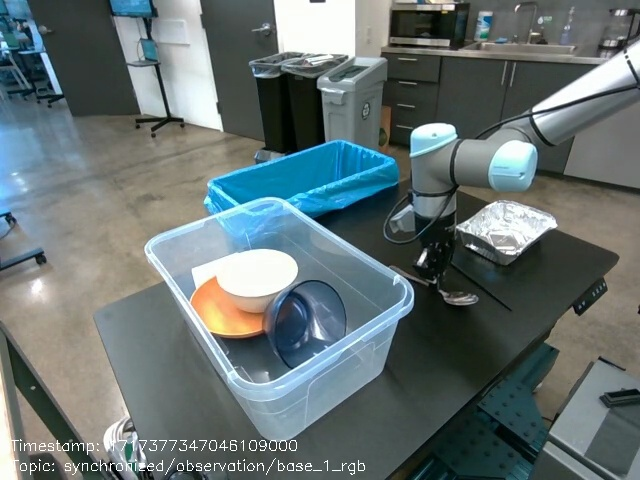

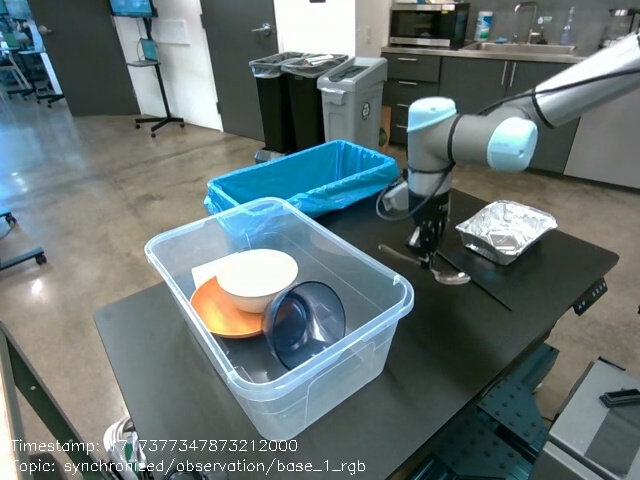

In [1248]:
from IPython.display import display, Image
import base64

start_image = example['start_image']-1
end_image = example['end_image']-1

frames = extract_frames_from_video(VIDEO_PATH, seconds_per_frame=0.5, start_frame=example['start_frame_of_segment'], end_frame=example['end_frame_of_segment'])

# Assuming 'frames' is your list of base64-encoded images
def display_specific_image(frames, image_index):
    if image_index < len(frames):
        img_data = frames[image_index]
        display(Image(data=base64.b64decode(img_data.encode("utf-8")), width=600))
    else:
        print("Image index out of range")

# Call the function with the desired image index
image_index = start_image  # For the 8th image
display_specific_image(frames, image_index)

image_index = end_image  # For the 8th image
display_specific_image(frames, image_index)

In [1249]:
new_start_frame, new_end_frame = calculate_expanded_range(example['start_frame'], 30, start_image, end_image, 2)
print(example['start_frame'],example['end_frame'])
print(new_start_frame, new_end_frame)

690 720
645 705


In [1250]:
example['task_name']

'Put Metal Spoon into Clear Plastic Box'

1116
30.0
Extracted 15 frames


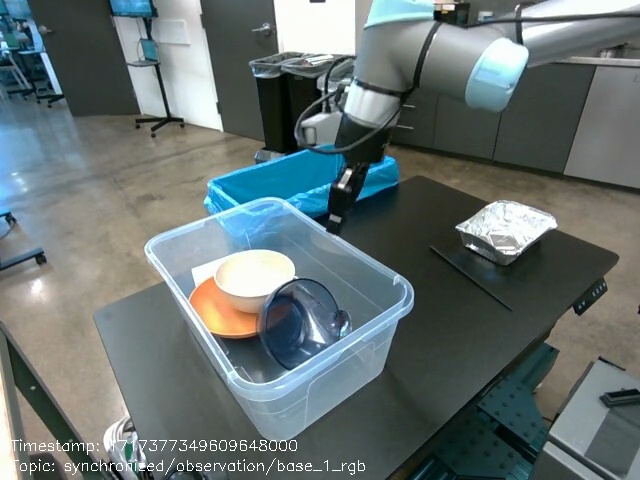

In [1251]:
# frames = extract_frames_from_video(VIDEO_PATH, seconds_per_frame=0.3, start_frame=new_start_frame, end_frame=new_end_frame)
frames = extract_frames_from_video(VIDEO_PATH, seconds_per_frame=0.25, start_frame=example['start_frame']-50, end_frame=example['start_frame']+50)

display_handle = display(None, display_id=True)
for idx, img in enumerate(frames):
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(1)
    

In [1252]:
example['start_frame']

690

### Displaying specific frame 

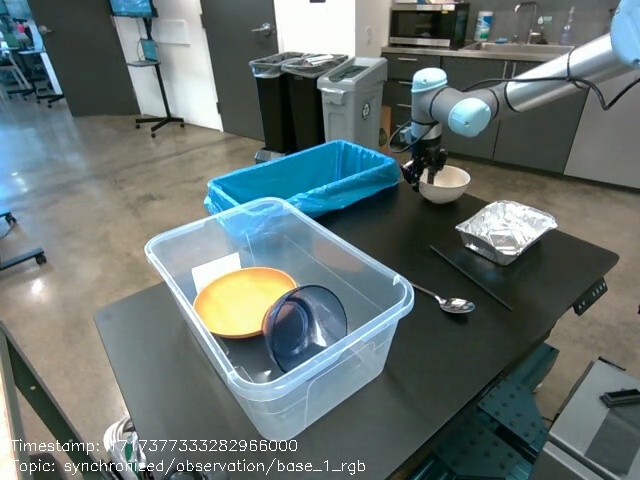

In [1198]:
import cv2
import base64
from IPython.display import display, Image

def extract_specific_frame(video_path, frame_number):
    video = cv2.VideoCapture(video_path)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = video.read()
    video.release()
    
    if success:
        _, buffer = cv2.imencode(".jpg", frame)
        img_data = base64.b64encode(buffer).decode("utf-8")
        return img_data
    else:
        print("Failed to read frame")
        return None

def display_image(base64_image):
    if base64_image:
        display(Image(data=base64.b64decode(base64_image), width=600))
    else:
        print("No image data to display")

# Example usage
frame_number = 430  # Specify the frame number you want to extract
base64_image = extract_specific_frame(VIDEO_PATH, frame_number)
display_image(base64_image)